# rocketman lab

In [56]:
import sys
sys.path.insert(0, 'C:\\Data\\Dev\\PyCharmProjects\\rocketman\\src')

## Laden und Anzeigen eines Beispiels

In [35]:
# import standard libs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk

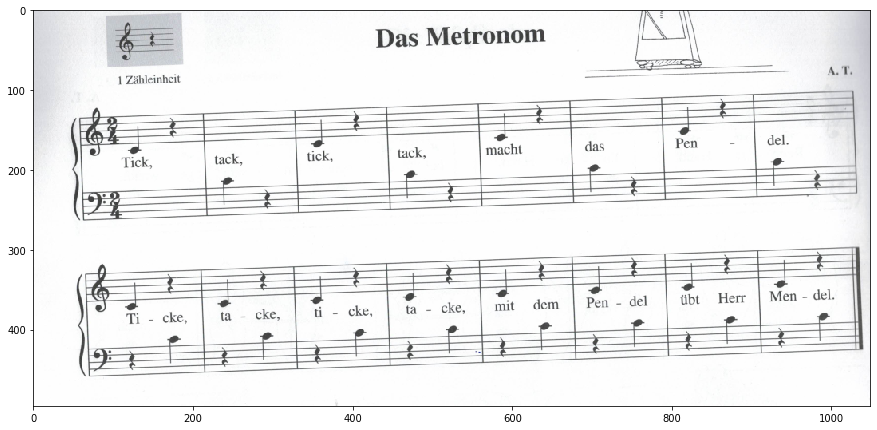

In [36]:
fname = "01"
ftype = ".png"
fpath = "C:\\Data\\Dev-Data\\music\\pieces\\"
filename = fpath + fname + ftype
image = plt.imread(filename)
plt.figure(figsize = (15,8))
plt.imshow(image)

## Vorverarbeitung: Grau- bzw. S/W-Umwandlung

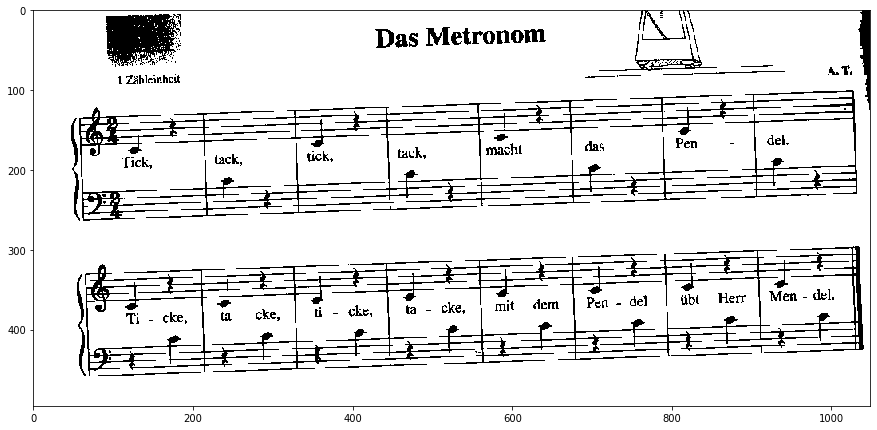

In [37]:
# konvertierung nach gray
image_gray = np.dot(image[...,:3], [0.299, 0.587, 0.114]) 
# konvertierung nach schwarz-weiss

## bei jpg Bilder zwischen 0 und 255
## bw_split = 100
## bei png Bildern zwisch 0 und 1
bw_split = 0.8
image_bw = np.array([[0 if pix < bw_split else 255 for pix in r] for r in image_gray])

plt.figure(figsize = (15,8))
plt.imshow(image_bw, cmap = plt.get_cmap('gray'))

## Vorverarbeitung: Image-Vector in Y/X-Koordindaten umwandeln 

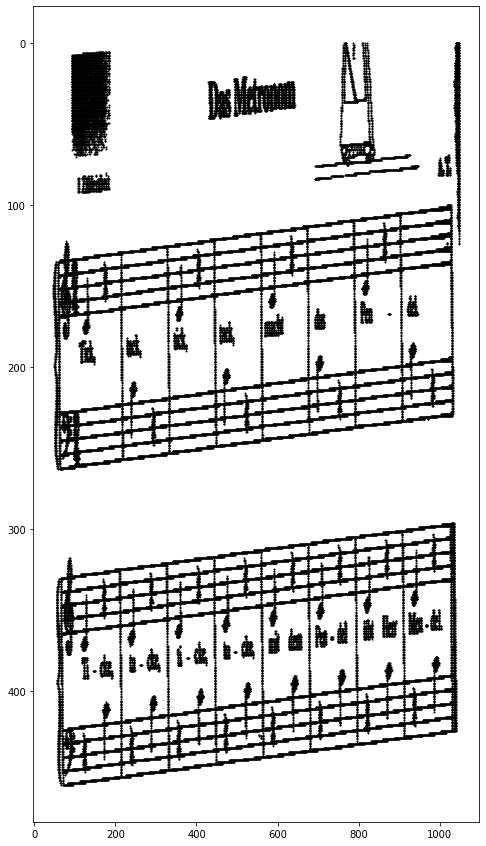

In [38]:
height, width = image_bw.shape

image_scatter = list()
for y in range (height):    
    for x in range (width):    
        pix = image_bw[y,x]
        if pix == 0:
            image_scatter.append ([x,y])
image_scatter_array = np.array (image_scatter)

plt.figure(figsize = (8,15))
ax = plt.gca()
ax.invert_yaxis()
plt.scatter (image_scatter_array[:,0],image_scatter_array[:,1],s=1,c="black")

## Clustering mit DBScan

In [39]:
from sklearn import cluster as cluster_models

model = cluster_models.DBSCAN(eps=10)
clusters = model.fit_predict (image_scatter_array)

## Bild mit Cluster-Kennzeichnung ausgeben

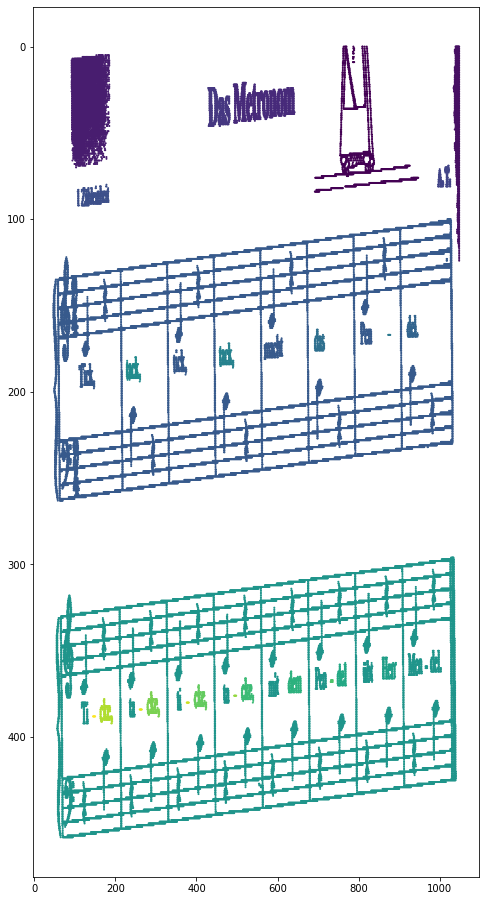

In [40]:
plt.figure(figsize = (8,16))
ax = plt.gca()
ax.invert_yaxis()
plt.scatter (image_scatter_array[:,0],image_scatter_array[:,1],s=1,c=clusters)

## Cluster auf dem Original ausgeben

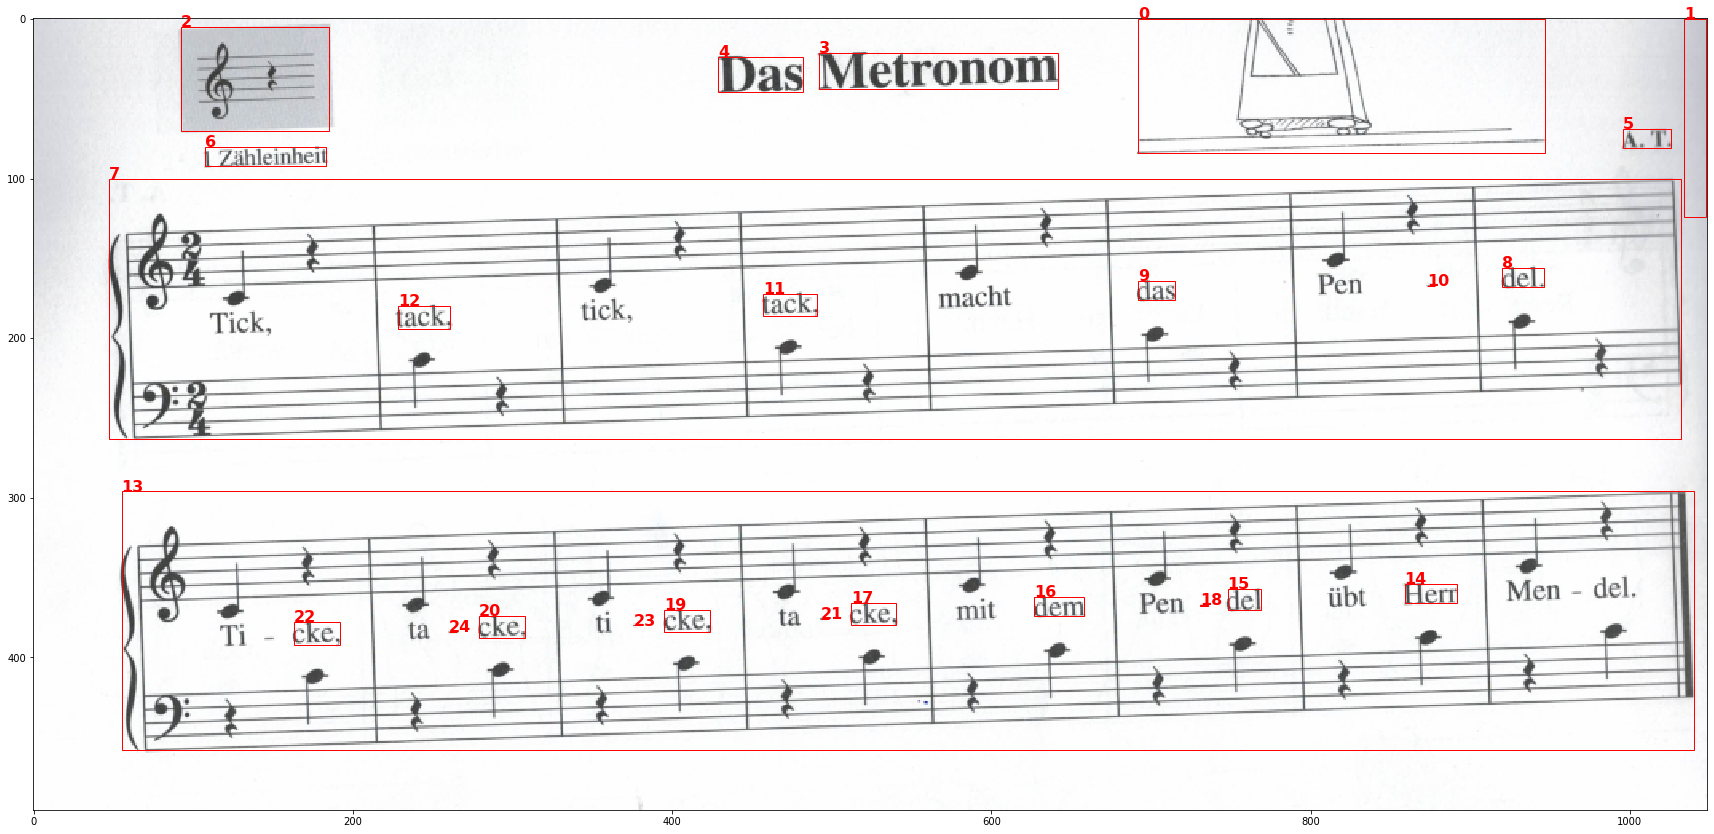

26 CLUSTER


In [41]:
import matplotlib.patches as patches

# ALTERNATIVE 1: AUF DEM ORIGINALS
fig,ax = plt.subplots(1,figsize = (30,16))
ax.imshow(image)

# ALTERNATIVE 2: AUF DEM SCATTERPLOT
#fig,ax = plt.subplots(1,figsize = (8,16))
#ax = plt.gca()
#ax.invert_yaxis()
#ax.scatter (image_scatter_array[:,0],image_scatter_array[:,1],s=1,c=clusters)

# RECHTECKE PRO CLUSTER BERECHNEN UND ZEICHNEN
# STEP 0: die Rechtecke für die Cluster werden später für die Vereinigung von Cluster benötigt
class Rectangle:
    def __init__(self, min_x, min_y, max_x, max_y, identificator):
        self.min_x = min_x
        self.min_y = min_y
        self.max_x = max_x
        self.max_y = max_y
        self.identificator = identificator

    def __repr__(self):
        return str(self.identificator) + ": " + str(self.min_x) + "/" + str(self.min_y) + "/" + str(self.max_x) + "/" + str(self.max_y)
        
    def intersects(self, other):
        return not (self.max_x < other.min_x or 
                    self.max_y < other.min_y or 
                    self.min_x > other.max_x or 
                    self.min_y > other.max_y)
    
    def vintersects(self, other):
        return      (self.max_x > other.min_x and other.max_x > self.min_x)
rects = list()
    
# STEP 1: für jedes identifizierte cluster alle Positionen in ein eigenes array übertragen
y = np.array (clusters)
num_cluster = y.max()

cluster_image_array = list()
for i in range (num_cluster):
    c = np.array([image_scatter_array[x] for x in range (1,y.shape[0]) if y[x]==i])
    
    # Sonderbehandlung für Aussreisser
    min_x = c[:,1].min()
    max_x = c[:,1].max()
    min_y = c[:,0].min()
    max_y = c[:,0].max()    
    if not (max_x-min_x) > (height - 50):
        cluster_image_array.append (c)
    
# STEP 2: aus dem array für das Cluster die min und max Werte der X und Y-Position ermitteln
for i in range (len(cluster_image_array)):
    cluster_image = cluster_image_array[i]

    min_x = cluster_image[:,1].min()
    min_y = cluster_image[:,0].min()
    max_x = cluster_image[:,1].max()
    max_y = cluster_image[:,0].max()

    r = Rectangle(min_x, min_y, max_x, max_y, i)
    rects.append (r)
    
    rect = patches.Rectangle((min_y,min_x),(max_y-min_y), (max_x-min_x),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch (rect)
    ax.text (min_y, min_x, str(i), fontdict={'weight':'bold', 'size':16}, color="red")

plt.show()
print (str(len (cluster_image_array)+1) + " CLUSTER")

## Überlappende Cluster kombinieren

cluster  7  collides with  8
cluster  9  collides with  26
cluster  10  collides with  27
cluster  11  collides with  28
cluster  12  collides with  29
cluster  13  collides with  14
cluster  15  collides with  31
cluster  16  collides with  32
cluster  17  collides with  33
cluster  18  collides with  34
cluster  19  collides with  35
cluster  20  collides with  36
cluster  21  collides with  37
cluster  22  collides with  38
cluster  23  collides with  39
cluster  24  collides with  40


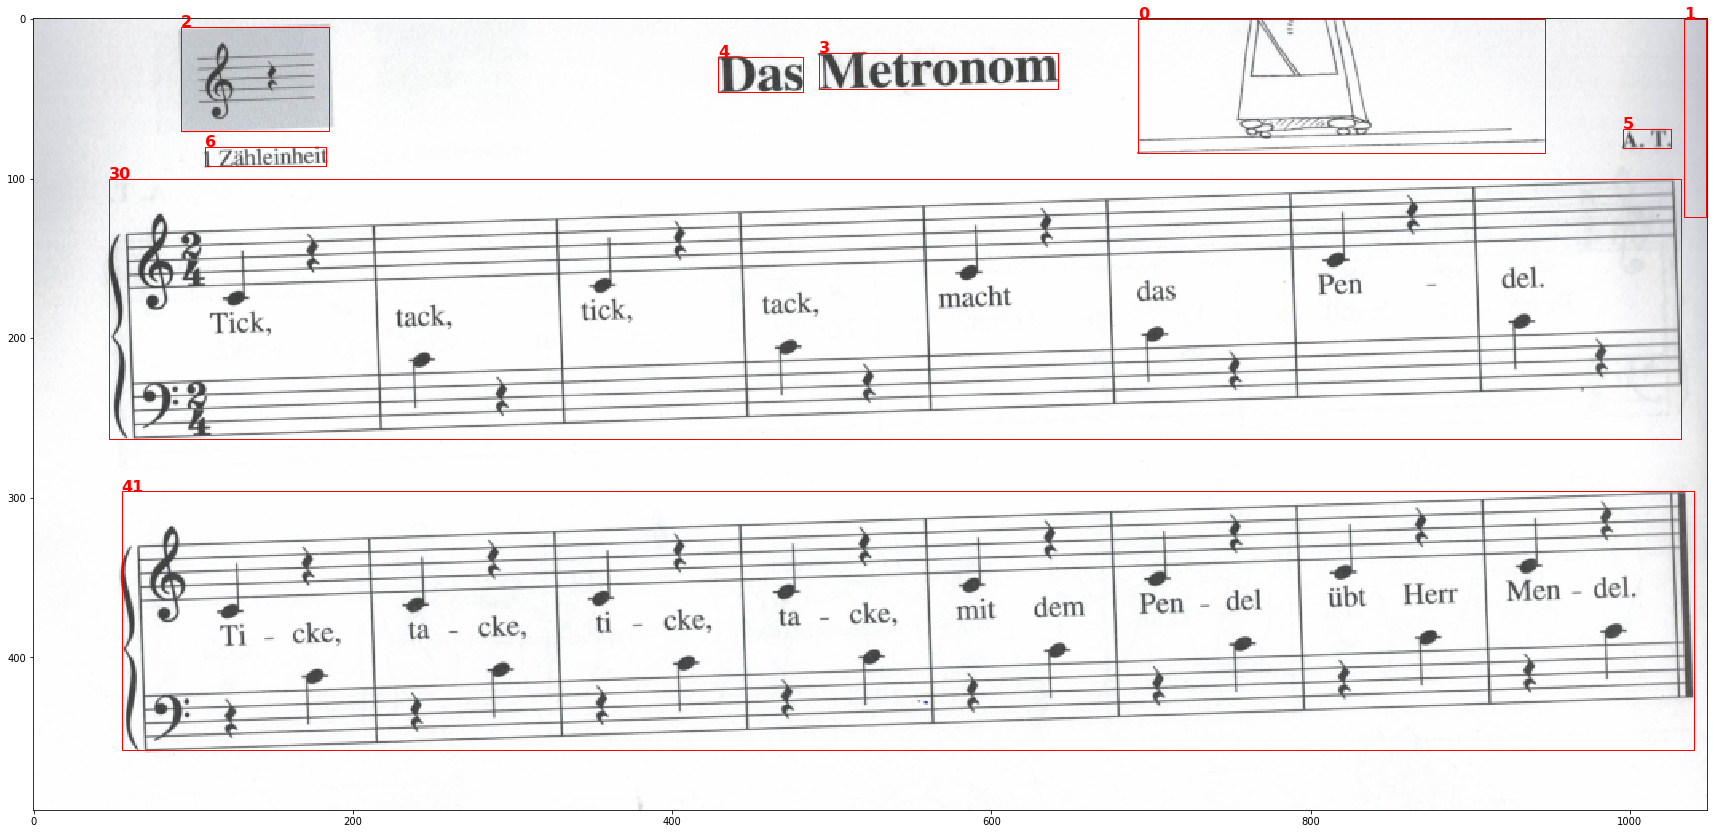

In [42]:
cnt = 0 
num_rects = len (rects)
while cnt<len(rects):
    rect = rects[cnt]
    # print (str(cnt)+": "+str(rect.identificator))
    for cnt2 in range(cnt + 1, len(rects)):
        rect2 = rects[cnt2]
        if rect.intersects (rect2):
            num_rects = num_rects + 1
            print ("cluster ", rect.identificator, " collides with ", rect2.identificator)
            #print ("-- add: ", num_rects)
            #print ("-- remove", rect.identificator)
            #print ("-- remove", rect2.identificator)

            ci1 = cluster_image_array[cnt]
            ci2 = cluster_image_array[cnt2]
            ci = np.concatenate ((ci1, ci2))
            cluster_image_array.append (ci)
            
            min_y = ci[:,0].min()
            max_y = ci[:,0].max()
            min_x = ci[:,1].min()
            max_x = ci[:,1].max()
            r = Rectangle(min_x, min_y, max_x, max_y, num_rects)
            rects.append (r)
            
            del (cluster_image_array[cnt])
            del (cluster_image_array[cnt2-1])

            del (rects[cnt])
            del (rects[cnt2-1])

            cnt = -1
            break
    cnt = cnt + 1

# neue Zeichnung
fig,ax = plt.subplots(1,figsize = (30,16))
ax.imshow(image)
for i in range (len(cluster_image_array)):
    cluster_image = cluster_image_array[i]
    min_y = cluster_image[:,0].min()
    max_y = cluster_image[:,0].max()
    min_x = cluster_image[:,1].min()
    max_x = cluster_image[:,1].max()
    rect = patches.Rectangle((min_y,min_x),(max_y-min_y), (max_x-min_x),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch (rect)
    ax.text (min_y, min_x, str(rects[i].identificator), fontdict={'weight':'bold', 'size':16}, color="red")
plt.show()

## Die einzelnen Bildbestandteile anzeigen und speichern

0


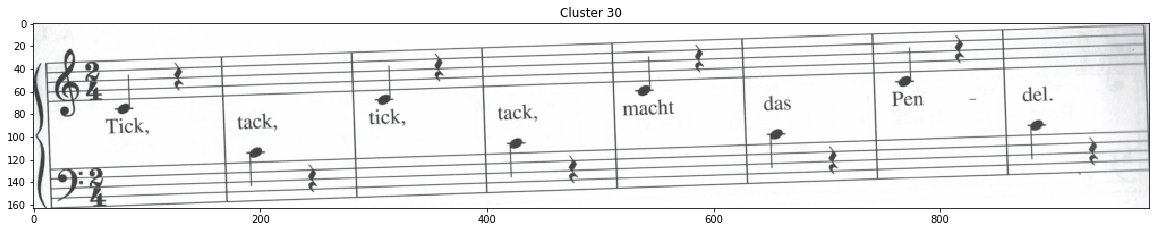

1


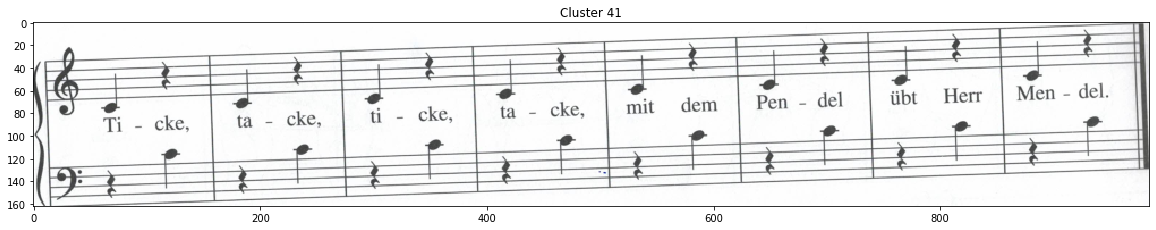

In [47]:
min_height = 100
min_width = 100

selected_images = []

cnt = 0
for i in range (len(cluster_image_array)):
    cluster_image = cluster_image_array[i]
    min_y = cluster_image[:,0].min()
    max_y = cluster_image[:,0].max()
    min_x = cluster_image[:,1].min()
    max_x = cluster_image[:,1].max()
    if max_y > min_y + min_height and max_x > min_x + min_width and max_y- min_y> max_x- min_x:
        print (cnt)
        selected_images.append (image[min_x:max_x,min_y:max_y])
        plt.figure(figsize = (20,10))
        plt.imshow(image[min_x:max_x,min_y:max_y])
        plt.title ("Cluster {}".format(rects[i].identificator))
        plt.savefig (fpath+fname+"_"+str(cnt)+ftype)
        plt.show()
        cnt = cnt + 1 


## image pre-processing with openCV
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html#gradients

In [49]:
import cv2
def plotit (img):
    plt.figure(figsize = (15,8))
    plt.imshow(img,cmap = 'gray')
    plt.show()

img = selected_images[0]    
#img = cv2.imread(filename,0)

# grey scale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#brighten
#matrix = np.ones(img.shape, dtype = "uint8") * 100    
#img = cv2.add(img, matrix)
#plotit (img)

# black & white
#retval, img = cv2.threshold(img, 10, 255, cv2.THRESH_OTSU)
#plotit (img)

# laplace edges
#img4 = cv2.Laplacian(img4,cv2.CV_32F)
#plotit (img4)

## sliding window
https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

In [50]:
import imageio
from IPython.display import HTML

img_height = image.shape[0]
img_width = image.shape[1]
print (img_width, " x ", img_height)

window_size = 30
step_size = 30
x = 0

images = []
crop_images = []
    
while x + window_size < img_width:
    clone = img.copy()    
    cv2.rectangle (clone,(x,0),(x+window_size,img_height), (0, 255, 0), 2)
    images.append (clone)
    
    crop_img = img[0:img_height+2, x:x+window_size]
    crop_images.append (crop_img)
    
    x = x + step_size  

imageio.mimsave("rocketman.gif", images)
HTML ("<iframe src ='./rocketman.gif' width='100%' height='500' frameborder='0'>")

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1049  x  496


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

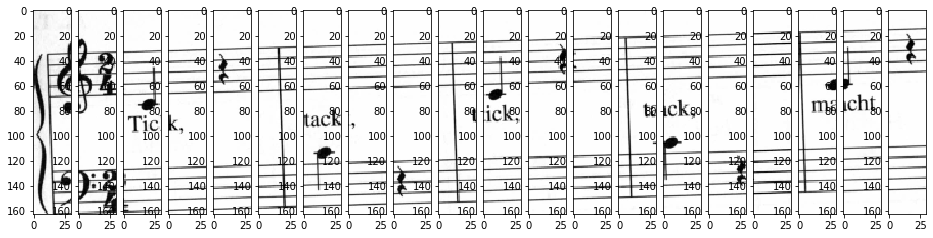

In [51]:
fig, axs = plt.subplots(1, 20, figsize=(16,8))

for i in range (0,20):
    axs[i].imshow(crop_images[i], cmap="gray")

Idee: immer das window davor und danach mit anschauen, und dann entscheiden

## density calculation

In [52]:
img_height = img.shape[0]
img_width = img.shape[1]
print (img_width, " x ", img_height)
print (img)

985  x  163
[[0.93915296 0.9469961  0.96268237 ... 0.848553   0.8524746  0.8524746 ]
 [0.9352314  0.9430745  0.96268237 ... 0.8524746  0.8524746  0.848553  ]
 [0.9469961  0.95483917 0.95876086 ... 0.8563961  0.848553   0.84070987]
 ...
 [0.99607843 0.99607843 0.9882353  ... 0.96312946 0.96312946 0.9592079 ]
 [0.99607843 0.99607843 0.99607843 ... 0.967051   0.967051   0.96312946]
 [0.99607843 0.99607843 0.99607843 ... 0.967051   0.967051   0.96312946]]


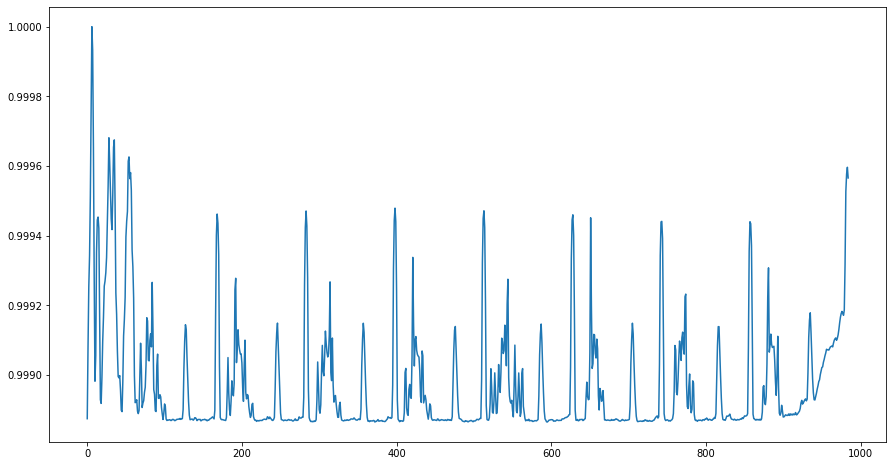

In [53]:
x = 0
density_array = []
while x < img_width:
    density = sum (255-img[:,x])
    density_array.append (density)
    x = x + 1

#rescale density to value 0 - 1
max_val = max (density_array)  
density_array = (density_array / max_val) 

plt.figure(figsize = (15,8))
plt.plot (density_array)
plt.show ()

## peak detect

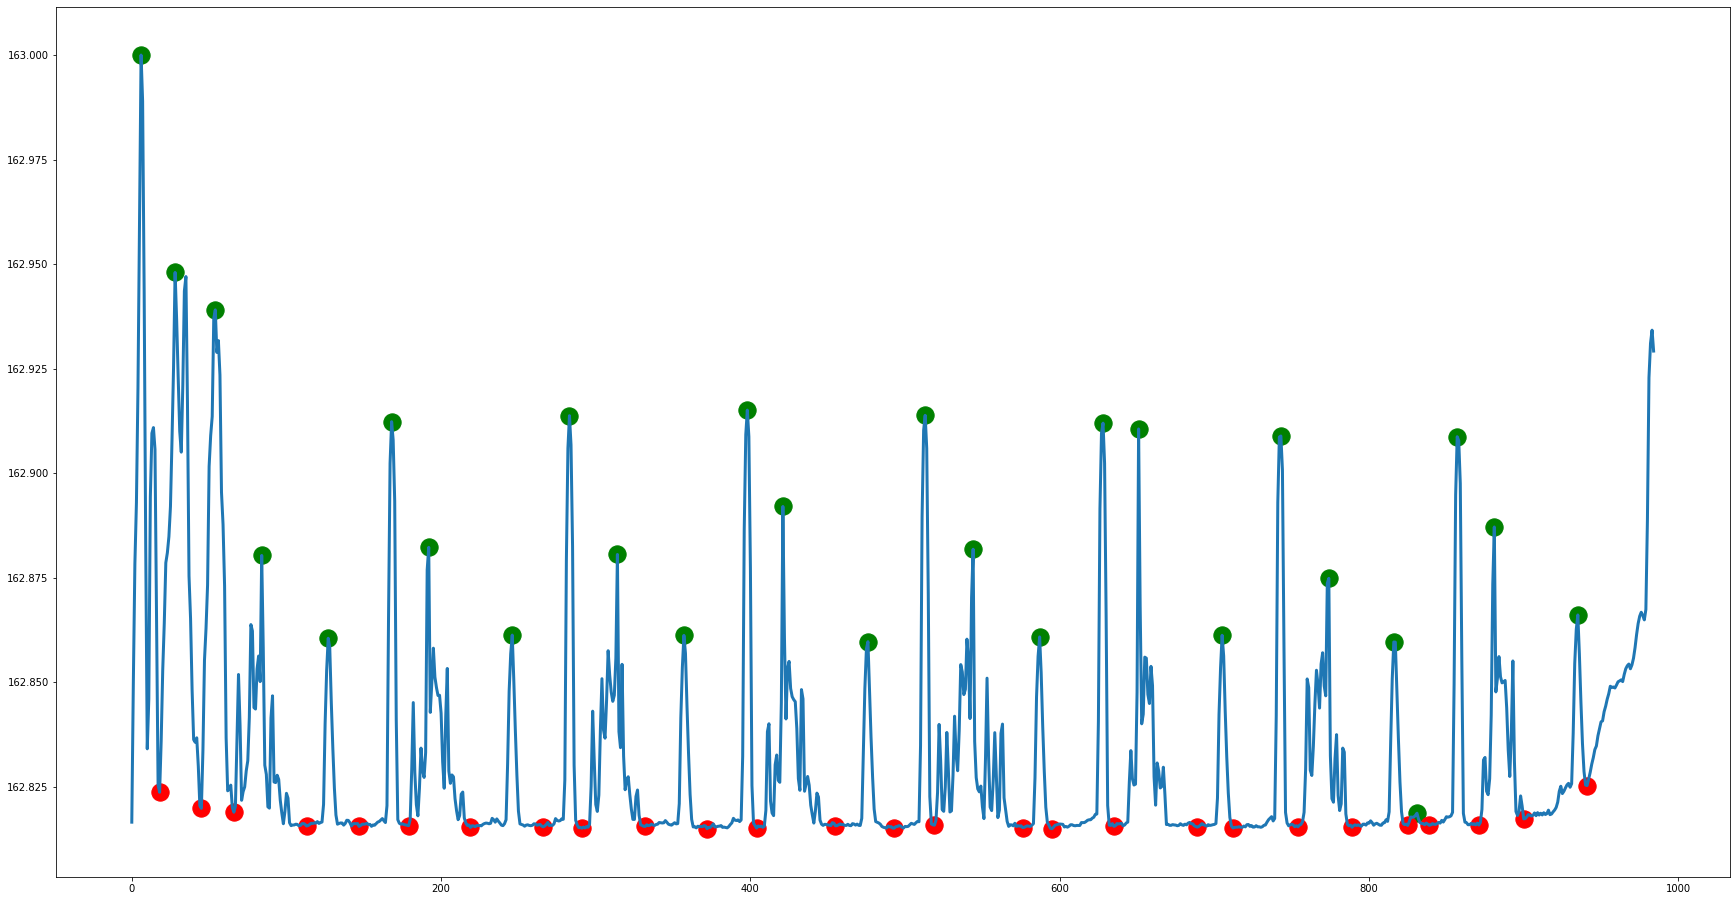

In [57]:
from peakdetect import peakdetect

peaks = peakdetect(density_array, lookahead=15)

lows = np.asarray (peaks[1])
xl = lows[:,0]
yl = lows[:,1]

highs = np.asarray(peaks[0])
xh = highs[:,0]
yh = highs[:,1]

fig, ax = plt.subplots(1,figsize = (30,16))
ax.plot (density_array*img_height, linewidth=3)
ax.scatter (xh,yh*img_height,s=300,c="green")
ax.scatter (xl,yl*img_height,s=300,c="red")
plt.show ()

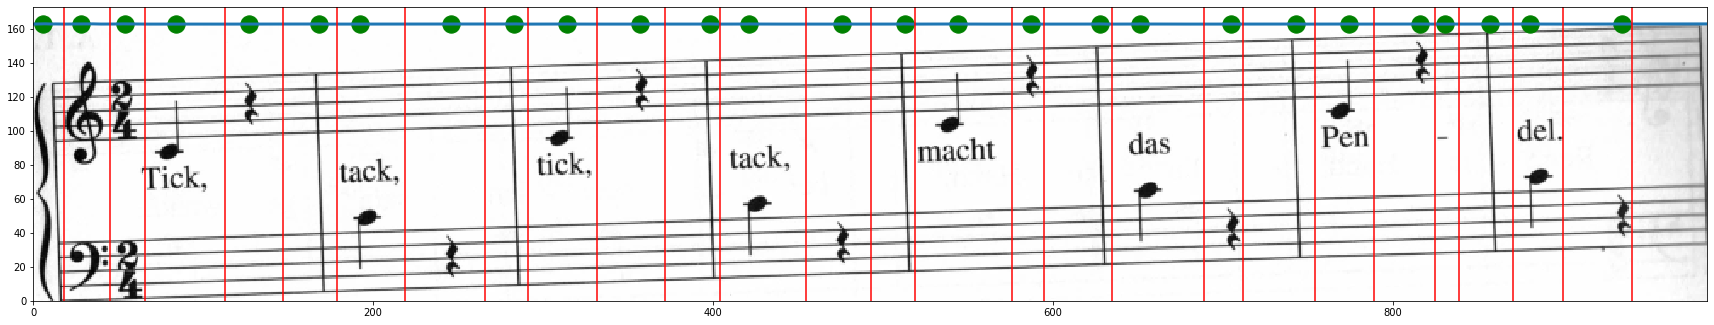

In [58]:
fig, ax = plt.subplots(1,figsize = (30,16))
ax.imshow(img, cmap='gray', extent=[0, img_width, 0, img_height])
ax.plot (density_array*img_height, linewidth=3)
ax.scatter (xh,yh*img_height,s=300,c="green")
for low in lows:
    ax.axvline (low[0],0,img_height,color="red")
plt.show ()


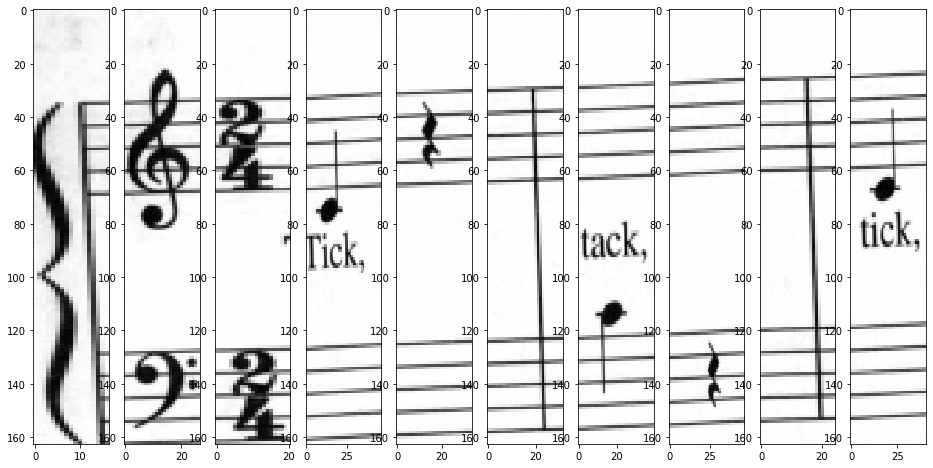

In [59]:
crops = 10
crop_images = []
fig, axs = plt.subplots(1,crops, figsize=(16,8))

x1 = 1
i = 0
for low in lows:
    x2 = int(low [0])
    crop_img = img[0:img_height, x1:x2]
    crop_images.append (crop_img)
    x1 = x2
    i = i+1
    
for i in range (0,min(crops,len(lows))):
    axs[i].imshow(crop_images[i],aspect='auto',cmap="gray")    

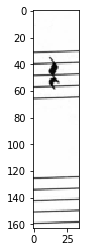

In [60]:
img = crop_images[4]
plt.imshow(img, cmap="gray")  
plt.show ()    

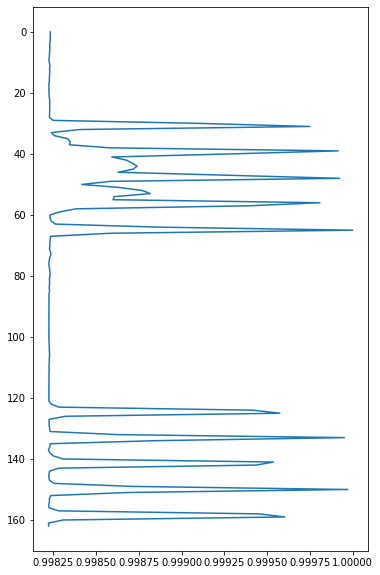

In [61]:
img_height = img.shape[0]
img_width = img.shape[1]
y = 0
density_array = []
while y < img_height:
    density = sum (255-img[y,:])
    density_array.append (density)
    y = y + 1

#rescale density to value 0 - 1
max_val = max (density_array)
density_array = (density_array / max_val) 

plt.figure(figsize = (6,10))
plt.gca().invert_yaxis()
plt.plot (density_array, np.arange(density_array.size))
plt.show ()

In [ ]:
inp = ""
for img in crop_images:
    plt.imshow(img, cmap="gray")  
    plt.show ()        
    inp = input()
    
    if inp is "x":
        break
    print(inp, end="\r")
    
print ("- done!")